In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import solve_for_masses as em
import mass_loss as ms
from numpy.random import normal
%matplotlib inline

from importlib import reload

In [2]:
reload(ms)

<module 'mass_loss' from '/Users/bcamposestrada/Library/CloudStorage/OneDrive-UniversityofCopenhagen/EvapMass/mass_loss.py'>

As an example we work with the famous Kepler-36 system, which contains a rocky and gaseous planet. Planet parameters are taken from Carter et al. (2012, Science 337 556). 

To start with we need to make some basic choices. First we need to assume the composition of the solid cores. This uses the Fortney et al. (2007, ApJ 659 1661) mass-radius relation. They can either be iron-rock or water-rock (both the iron fraction and ice fraction cannot be non-zero). Xiron=1/3 will consider an "Earth-like" composition of 1/3 iron and 2/3 silicate rock.

In [3]:
Xiron = 1./3.
Xice = 0.

As discussed in the paper (Owen & Campos Estrada, in prep), one needs to choose a Kelvin-Helmholtz timescale for the H/He atmospheres at which to do the comparision (i.e. at what age is mass-loss important), the answer is very weakly dependent on this value, here we pick the standard value of 100 Myr.

In [4]:
Tkh_Myr=100.

Now we input the planetary and stellar parameters and their errors. Any errors in the Carter et al. (2012) paper that are not symmetric we just make symmetric crudely using addition in quadrature. 

In [5]:
K36s_M = 1.071 # stellar mass,  solar masses
K36s_Mer = 0.043 # stellar mass error, solar masses
K36s_Teff = 5911 # Stellar effective temperature, K
K36s_Teffer = 66 # stellar effective temperature error, K
K36s_R = 1.626 # stellar radius, solar radii - note we should really use the MS radii but this is and example.
K36s_Rer=0.019 # stellar radius error, solar radii 
K36s_age=6800 # stellar age, Myr
K36s_age_er=1000. #stellar age error, Myr

#radius in earth unit and period in days + errors for planet b
K36b_R = 1.486
K36b_Rer=0.035
K36b_P = 13.83989
K36b_Per = np.sqrt(0.00082**2.+0.00060**2.) # make period errors symmetric

#radius in earth unit and period in days + errors for planet c
K36c_R = 3.679
K36c_Rer=0.054
K36c_P = 16.23855
K36c_Per = np.sqrt(0.00038**2.+0.00054**2.)

A note on the efficiency parameter. The code contains three options for the efficiency parameter in the mass-loss models.

1. Option 1, is to use a constant efficiency parameter.
2. Option 2, is to use the scaling $\eta \propto v_{\rm esc}^{-2}$, where $v_{\rm esc}$ is the escape velocity from the planet's surface. This fit was provided in Owen & Wu (2017) as an approximation of the hydrodynamic models. It works well for typical sub-neptunes; however, fails when the escape temperature from the planet is smaller than the outflow temperature. In this case it overestimates the efficiency. This occurs for larger planets, or planet's where the minimum required core-mass is low. 
3. Option 3 (Default) is a full fit to the Owen & Jackson (2012) mass-loss rates. It provides a normalised value of the efficiency (scaled to the highest value in the table). For very puffy planets, photoevaporation does not occur, but rather Roche Lobe overflow (grey region in Figure 5 of Owen & Jackson 2012). If this happens the efficiency value is simply extrapolated at a constant value for the last hydrodyanmic one. 
4. Additional options - you are free to modify the "efficiency" function in mass_loss.py to include your own efficiency function

In [6]:
# set the efficiency option 
eff_option = 3

Now do the calculation for the minimum mass of Kepler-36c to be consistent with photoevaporation assuming the mean values for all parameters.

The location of the radius valley can be chosen. The default is set to 1.8 Rearth, but this is generally only true for sun-like stars. One should change the location of the valley accordingly (for example for M-dwarfs the valley is generally at smaller radii - see van Eylen et al. 2021). 

In [7]:
valley_loc=1.8

In [8]:
# evaluate minimum mass for the mean value and print it

system = em.psystem('Kepler36')
system.add_planet('36b',K36b_R,K36b_Rer,K36b_P,K36b_Per)
system.add_planet('36c',K36c_R,K36c_Rer,K36c_P,K36c_Per)
system.star.mass=K36s_M
system.star.radius=K36s_R
system.star.Teff=K36s_Teff
system.star.age = K36s_age
system.update_planet_info()
system.above_or_below_valley()
system.mass_rocky(Xiron,Xice)

ms.find_hardest_rocky(system,Tkh_Myr,Xiron,Xice,eff_option)

Mout, flag = ms.min_mass_gaseous(system.planets[0],system.planets[1],Tkh_Myr,Xiron,Xice,system.star.age,eff_option)
Mmedian = np.copy(Mout)

print(Mmedian,'Mearth')

8.412384425520381 Mearth


However, given the stellar and planetary parameters contain errors these must be included, therefore we assume the errors are gaussian and randonly sample them. Here we use 1000 samples, but a value should be chosen such that the upper-limit is converged.  

In [9]:
Mout_error= np.zeros(1000)
flag_out = np.zeros(1000,dtype=np.int8)

for i in range(np.size(Mout_error)):
    
    K36b_R_use = normal(K36b_R,K36b_Rer,1)
    K36b_P_use = normal(K36b_P,K36b_Per,1)
    
    K36c_R_use = normal(K36c_R,K36c_Rer,1)
    K36c_P_use = normal(K36c_P,K36c_Per,1)
    
    system = em.psystem('Kepler36_%d' %i)
    system.add_planet('36b',K36b_R_use,K36b_Rer,K36b_P_use,K36b_Per)
    system.add_planet('36c',K36c_R_use,K36c_Rer,K36c_P_use,K36c_Per)
    system.star.mass=normal(K36s_M,K36s_Mer,1)
    system.star.radius=normal(K36s_R,K36s_Rer,1)
    system.star.Teff=normal(K36s_Teff,K36s_Teffer,1)
    system.star.age = normal(K36s_age,K36s_age_er,1)
    system.update_planet_info()
    system.above_or_below_valley()
    system.mass_rocky(Xiron,Xice)
    
    ms.find_hardest_rocky(system,Tkh_Myr,Xiron,Xice,eff_option)

    Mout, flag = ms.min_mass_gaseous(system.planets[0],system.planets[1],Tkh_Myr,Xiron,Xice,system.star.age,eff_option)
    
    Mout_error[i] = Mout
    flag_out[i]=flag

Now plot the resulting distribution and calculate the 95% upper-limit, the 95% upperlimit is plotted as a dashed line, the actual measured mass is plotted as the dotted line. This indicates (as known from previous work - Lopez & Fortney 2013, Owen & Morton 2016) that Kepler-36 is consistent with the photoevaporation model. The value to quote, as we are concerned with the minimum mass to be consistent is something like the 95% upper-limit, not the mean or meadian value. 

The 95% upper limit to be consistent with photoevaporation is
6.910740523238341 Mearth


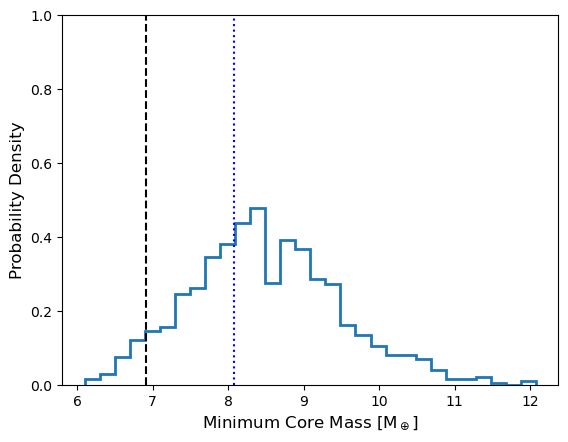

In [10]:
plt.hist(Mout_error,bins=30,density=False,histtype='step',lw=2)
plt.plot([(np.percentile(Mout_error,5.)),(np.percentile(Mout_error,5.))],[0.,1.],'--',color='k')
plt.plot([8.08,8.08],[0.,1.],':',color='b')
plt.ylim((0.,1.))
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/len(Mout_error),3))
plt.ylabel('Probability Density',fontsize=12)
plt.xlabel(r'Minimum Core Mass [M$_\oplus$]',fontsize=12)
print('The 95% upper limit to be consistent with photoevaporation is')
print((np.percentile(Mout_error,5.)),'Mearth')

Now we will run for the two other efficiency options to show the effect on the result

In [11]:
eff_option = 1

Mout_error_1= np.zeros(1000)
flag_out_1= np.zeros(1000,dtype=np.int8)

for i in range(np.size(Mout_error)):
    
    K36b_R_use = normal(K36b_R,K36b_Rer,1)
    K36b_P_use = normal(K36b_P,K36b_Per,1)
    
    K36c_R_use = normal(K36c_R,K36c_Rer,1)
    K36c_P_use = normal(K36c_P,K36c_Per,1)
    
    system = em.psystem('Kepler36_%d' %i)
    system.add_planet('36b',K36b_R_use,K36b_Rer,K36b_P_use,K36b_Per)
    system.add_planet('36c',K36c_R_use,K36c_Rer,K36c_P_use,K36c_Per)
    system.star.mass=normal(K36s_M,K36s_Mer,1)
    system.star.radius=normal(K36s_R,K36s_Rer,1)
    system.star.Teff=normal(K36s_Teff,K36s_Teffer,1)
    system.star.age = normal(K36s_age,K36s_age_er,1)
    system.update_planet_info()
    system.above_or_below_valley()
    system.mass_rocky(Xiron,Xice)
    
    ms.find_hardest_rocky(system,Tkh_Myr,Xiron,Xice,eff_option)

    Mout, flag = ms.min_mass_gaseous(system.planets[0],system.planets[1],Tkh_Myr,Xiron,Xice,system.star.age,eff_option)
    
    Mout_error_1[i] = Mout
    flag_out_1[i]=flag

In [12]:
eff_option = 2

Mout_error_2= np.zeros(1000)
flag_out_2= np.zeros(1000,dtype=np.int8)

for i in range(np.size(Mout_error)):
    
    K36b_R_use = normal(K36b_R,K36b_Rer,1)
    K36b_P_use = normal(K36b_P,K36b_Per,1)
    
    K36c_R_use = normal(K36c_R,K36c_Rer,1)
    K36c_P_use = normal(K36c_P,K36c_Per,1)
    
    system = em.psystem('Kepler36_%d' %i)
    system.add_planet('36b',K36b_R_use,K36b_Rer,K36b_P_use,K36b_Per)
    system.add_planet('36c',K36c_R_use,K36c_Rer,K36c_P_use,K36c_Per)
    system.star.mass=normal(K36s_M,K36s_Mer,1)
    system.star.radius=normal(K36s_R,K36s_Rer,1)
    system.star.Teff=normal(K36s_Teff,K36s_Teffer,1)
    system.star.age = normal(K36s_age,K36s_age_er,1)
    system.update_planet_info()
    system.above_or_below_valley()
    system.mass_rocky(Xiron,Xice)
    
    ms.find_hardest_rocky(system,Tkh_Myr,Xiron,Xice,eff_option)

    Mout, flag = ms.min_mass_gaseous(system.planets[0],system.planets[1],Tkh_Myr,Xiron,Xice,system.star.age,eff_option)
    
    Mout_error_2[i] = Mout
    flag_out_2[i]=flag

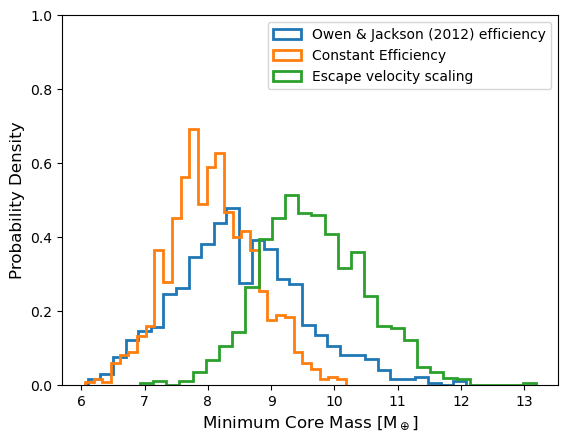

In [13]:
## Now plot
plt.hist(Mout_error,bins=30,density=False,histtype='step',lw=2,label='Owen & Jackson (2012) efficiency')
plt.hist(Mout_error_1,bins=30,density=False,histtype='step',lw=2,label='Constant Efficiency')
plt.hist(Mout_error_2,bins=30,density=False,histtype='step',lw=2,label='Escape velocity scaling')
plt.ylim((0.,1.))
locs, _ = plt.yticks()
plt.yticks(locs,np.round(locs/len(Mout_error),3))
plt.ylabel('Probability Density',fontsize=12)
#plt.xlabel(r'Minimum Core Mass [M$_\oplus$]',fontsize=12)
plt.legend(loc=0)

We see for planets like Kepler-36c, which contain a large amount of H/He today (relative to other sub-neptunes ~10% compared to 1-2%) the choice of efficiency parameter matters. At young ages these inflated planets with massive H/He envelopes are large. At this point advective energy losses become important the efficiency of the outflow drops with falling escape velocity. 